## Problem 1: GAN for Data Imbalance Problem
Most industries seriously consider and control their yield rate of production. For this reason, a huge amount of cost is required to control the yield rate and many industries try to replace this yield inspection process to reduce cost. However, the acquisition data from the industry are mostly normal data and seldomly fault data. (generally about less than 5% of normal data)

In this case, even if the deep learning model is a biased model (i.e., it consider every data as normal class), the accuracy would be 95%. So, in this case, we can't believe the result from the deep learning model.

One way to solve this problem is the 'data generation' method. In this problem, we are going to solve the classification problem for imbalanced data by the GAN model.

Download data from here.

- data format: pkl
- number of data: one-6000, seven-300

Note: strongly recommend you to use GPU rather than CPU. (you can use CoLab GPU for free)

In [1]:
import os
import pickle
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

2021-12-09 13:11:00.039776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-12-09 13:11:02.097466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 13:11:02.104144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-09 13:11:02.983013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-09 13:11:02.983847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.54

True

021-12-09 13:11:02.985303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 3 with properties: 
pciBusID: 0000:af:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-09 13:11:02.985368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-09 13:11:02.989491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-09 13:11:02.989675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-12-09 13:11:02.993609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2021-12-09 13:11:02.994419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuran

(1) Load and preprocess data.

Step 1: load
- one.pkl
- seven.pkl

In [3]:
with open('PS10_data_files/one.pkl', 'rb') as f:
    one_data = pickle.load(f)
    
with open('PS10_data_files/seven.pkl', 'rb') as f:
    seven_data = pickle.load(f)

In [4]:
one_data.shape, seven_data.shape

((6000, 784), (300, 784))

Step 2: convert the loaded data to a binary image

In [5]:
one_data = np.where(one_data > 0, 1, 0)
seven_data = np.where(seven_data > 0, 1, 0)

Step 3: split into train/test dataset
- one train index: 0~999
- one test index: 1000~6000
- seven train index: 0~4 (only five images)
- seven test index: 5~300

In [6]:
one_train_x = one_data[:1000]
one_test_x = one_data[1000:]

seven_train_x = seven_data[:5]
seven_test_x = seven_data[5:]

Step 4: labeling
- one-hot encoding

In [7]:
one_train_y = np.tile([1, 0], 1000).reshape(-1, 2)
one_test_y = np.tile([1, 0], 5000).reshape(-1, 2)

seven_train_y = np.tile([0, 1], 5).reshape(-1, 2)
seven_test_y = np.tile([0, 1], 295).reshape(-1, 2)

In [8]:
one_train_y.shape, one_test_y.shape, seven_train_y.shape, seven_test_y.shape

((1000, 2), (5000, 2), (5, 2), (295, 2))

In [9]:
train_x = np.vstack([one_train_x, seven_train_x])
test_x = np.vstack([one_test_x, seven_test_x])

train_y = np.vstack([one_train_y, seven_train_y])
test_y = np.vstack([one_test_y, seven_test_y])

train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

Step 5: batchmaker
- train and test batchmakers

In [10]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    
    data_shuffle = [data[i] for i in idx[:num]]
    labels_shuffle = [labels[i] for i in idx[:num]]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

(2) Conduct the binary classification by convolution neural network (CNN) model.

Structure

- First convolution layer

  -  filter size:  3×3 
  - channel:  32 
  - max pooling:  2×2 
- Second convolution layer

  - filter size:  3×3 
  - channel:  64 
  - max pooling:  2×2 
- Nonlinear activation: ReLu

In [11]:
# Build and train a model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(3, 3),
                           padding='SAME',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(3, 3), 
                           padding='SAME',
                           activation='relu',
                           input_shape=(14, 14, 32)),
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Flatten(),
  
    tf.keras.layers.Dense(units=2, activation='softmax')])

2021-12-09 13:11:12.864806: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-09 13:11:12.866457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-09 13:11:12.867257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-09 13:11:12.867957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-1

Model Training

- Optimizer: AdamOptimizer
- Learning rate:  0.001 
- Epoch:  20 

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics='accuracy')
cnn_model.fit(train_x, train_y, epochs=20)

2021-12-09 13:11:16.054308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-09 13:11:16.055182: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100000000 Hz


Epoch 1/20


2021-12-09 13:11:16.588926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-09 13:11:17.145878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-09 13:11:19.481433: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-09 13:11:19.731900: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


32/32 [==============================] - 38s 555ms/step - loss: 0.2681 - accuracy: 0.9337
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0367 - accuracy: 0.9953
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0274 - accuracy: 0.9946
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0075 - accuracy: 0.9986
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0121 - accuracy: 0.9992
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 0.9997
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9991
Epoch 8/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 9/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 3.9997e-04 - accuracy: 1.0000
Epoch 11/20
32/32 [====

Model Test

- radom image test
- one image test
- seven image test

you should calculate the test accuracy

In [13]:
# test_dataset
test_loss, test_acc = cnn_model.evaluate(test_x, test_y)

166/166 [==============================] - 9s 54ms/step - loss: 0.0240 - accuracy: 0.9936


In [14]:
# One image test
one_loss, one_acc = cnn_model.evaluate(test_x[:5000], test_y[:5000])

157/157 [==============================] - 9s 58ms/step - loss: 0.0019 - accuracy: 0.9996


In [15]:
# Seven image test
seven_loss, seven_acc = cnn_model.evaluate(test_x[5000:], test_y[5000:])

10/10 [==============================] - 8s 891ms/step - loss: 0.3983 - accuracy: 0.8915


(3) As you can see, the accuracy is low for images of seven. We would like to generate more images of seven by a GAN model to overcome the data imbalance problem. In this problem you should use convolutional layers instead of ANN layer for both a generator and a discriminator.

Generator: deconvolution layer (= conv2d_transpose)

- Input layer: 100
- First deconvolution layer
  - filter size: 7 × 7 
  - channel:  64 
  - stride: (1, 1) 
  - padding: 'VALID'


- Second deconvolution layer:
  - filter size: 4 × 4 
  - channel: 32 
  - stride: (2, 2) 
  - padding: 'SAME'


- Third deconvolution layer
  - filter size: 4 × 4 
  - channel: 1 
  - stride: (2, 2) 
  - pading: 'SAME'

In [16]:
# Generator
generator = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 1, 100), 
                            input_shape=(None, 100)),
    
    tf.keras.layers.Conv2DTranspose(filters=64, 
                                    kernel_size=(7, 7),
                                    strides=(1, 1), 
                                    padding='VALID',
                                    activation='relu',
                                    input_shape=(1, 1, 100)), 

    tf.keras.layers.Conv2DTranspose(filters=32, 
                                    kernel_size=(4, 4),
                                    strides=(2, 2),
                                    padding='SAME',
                                    activation='relu',
                                    input_shape=(7, 7, 64)),
    
    tf.keras.layers.Conv2DTranspose(filters=1, 
                                    kernel_size=(4, 4),
                                    strides=(2, 2),
                                    padding='SAME',
                                    activation='relu',
                                    input_shape=(7, 7, 64))])

In [17]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          313664    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        32800     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         513       
Total params: 346,977
Trainable params: 346,977
Non-trainable params: 0
_________________________________________________________________


Discriminator: convolution layer

- Input layer: 28 x 28 x 1
- First convolution layer
  - filter size: 3 × 3
  - channel: 32 
  - padding: 'SAME'


- Second convolution layer:
  - filter size: 3 × 3 
  - channel: 64
  - padding: 'SAME'


- no polling layer

In [18]:
# Discriminator
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=(3, 3),
                           padding='SAME',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    
    tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(3, 3),
                           padding='SAME',
                           activation='relu',
                           input_shape=(14, 14, 32)),
    
    tf.keras.layers.Flatten(),
  
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

In [19]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5017700   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,036,617
Trainable params: 5,036,617
Non-trainable params: 0
_________________________________________________________________


Training

- D_LR: 0.00004
- G_LR: 0.00008
- Max iteration: 5500
- Optimizer: AdamOptimizer

In [20]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004), 
                      loss='binary_crossentropy')

In [21]:
# Combined model
combined_input = tf.keras.layers.Input(shape=(100))
generated = generator(combined_input)
discriminator.trainable = False
combined_output = discriminator(generated)

combined = tf.keras.models.Model(inputs=combined_input, outputs=combined_output)

In [22]:
combined.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         346977    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 5036617   
Total params: 5,383,594
Trainable params: 346,977
Non-trainable params: 5,036,617
_________________________________________________________________


In [23]:
combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008), 
                 loss='binary_crossentropy')

In [24]:
def make_noise(samples):
    return np.random.normal(0, 1, [samples, 100])

def plot_generated_images(generator, samples=3):
    noise = make_noise(samples)
    
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(samples, 28, 28)
    
    for i in range(samples):
        plt.subplot(1, samples, i+1)
        plt.imshow(generated_images[i], 'gray', interpolation='nearest')
        plt.axis('off')
        plt.tight_layout()
        
    plt.show()

Iteration: 0
Discriminator Loss: 1.3920872211456299
Generator Loss: 0.6932193040847778


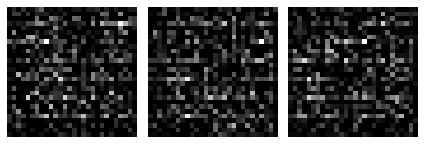

Iteration: 500
Discriminator Loss: 0.02885674498975277
Generator Loss: 8.37802505493164


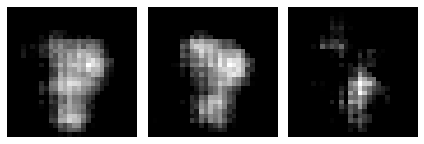

Iteration: 1000
Discriminator Loss: 0.01626079430570826
Generator Loss: 8.438737869262695


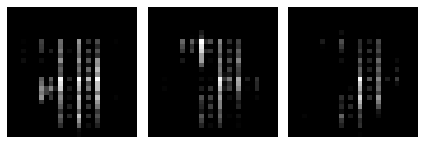

Iteration: 1500
Discriminator Loss: 0.12157605931861326
Generator Loss: 6.538941383361816


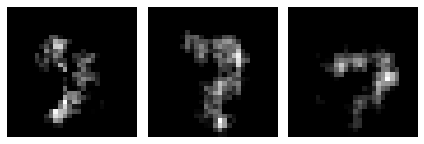

Iteration: 2000
Discriminator Loss: 0.038133337162435055
Generator Loss: 6.366779804229736


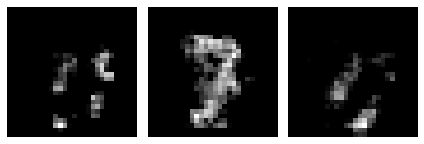

Iteration: 2500
Discriminator Loss: 0.02683158405125141
Generator Loss: 5.128226280212402


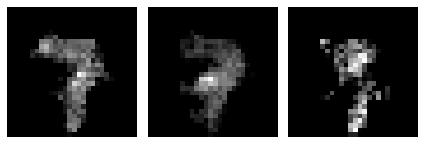

Iteration: 3000
Discriminator Loss: 0.02471302915364504
Generator Loss: 4.68800687789917


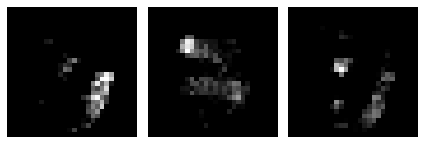

Iteration: 3500
Discriminator Loss: 0.013490641955286264
Generator Loss: 5.689648628234863


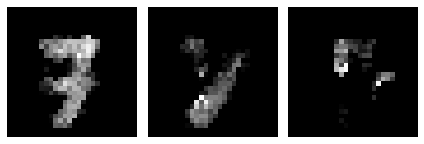

Iteration: 4000
Discriminator Loss: 0.02978332748170942
Generator Loss: 7.075987339019775


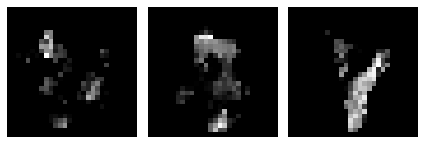

Iteration: 4500
Discriminator Loss: 0.008924286521505564
Generator Loss: 7.835171699523926


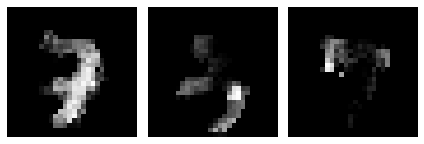

Iteration: 5000
Discriminator Loss: 0.01404539094073698
Generator Loss: 6.611810207366943


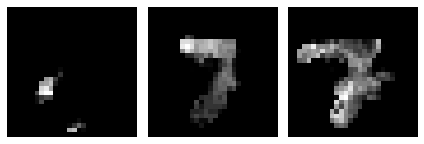

In [25]:
n_iter = 5500
batch_size = 5

fake = np.zeros(batch_size)
real = np.ones(batch_size)

for i in range(n_iter):
    # Train Discriminator
    noise = make_noise(batch_size)
    generated_images = generator.predict(noise)

    idx = np.random.randint(0, train_x[1000:].shape[0], batch_size)
    real_images = train_x[1000:][idx]

    D_loss_real = discriminator.train_on_batch(real_images, real)
    D_loss_fake = discriminator.train_on_batch(generated_images, fake)
    D_loss = D_loss_real + D_loss_fake
    
    # Train Generator
    noise = make_noise(batch_size)    
    G_loss = combined.train_on_batch(noise, real)
    
    if i % 500 == 0:
        print('Iteration:', i)
        print('Discriminator Loss:', D_loss)
        print('Generator Loss:', G_loss)

        plot_generated_images(generator)

Generated Images

- Convert generated image to binary image
- original one images:original seven images + generated fake seven images = 1:1

In [26]:
# generated data
# N = len(one) - len(seven)
def generate_data(generator, samples):
    noise = make_noise(samples)
    
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(samples, 28, 28, 1)
    
    return generated_images

In [27]:
one_train_x.shape, seven_train_x.shape

((1000, 784), (5, 784))

In [28]:
N = len(one_train_x) - len(seven_train_x) # 995개의 가짜 7 이미지를 생성

fake_seven_x = generate_data(generator, N)
fake_seven_y = np.tile([0, 1], N).reshape(-1, 2)

In [29]:
fake_seven_x.shape, fake_seven_y.shape

((995, 28, 28, 1), (995, 2))

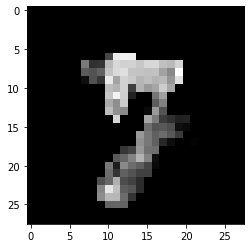

In [36]:
# Randomly plot one generated image among N
plt.imshow(fake_seven_x[np.random.randint(N)].reshape(-1, 28), 'gray')
plt.show()

(4) Train the CNN model again using the original and generated (or augmented) data.

- stack the generated data and original train data of seven
- define new train data by putting new seven train and one train data altogether
- define new train label
- use the same CNN structure

In [37]:
# stack the generated data and original train data of seven
# define new train data by putting new seven train and one train data altogether
new_train_x = np.vstack([train_x, fake_seven_x])
new_train_y = np.vstack([train_y, fake_seven_y])

In [38]:
print('new_train_data:\t{} {}'.format(new_train_x.shape, new_train_y.shape))

new_train_data:	(2000, 28, 28, 1) (2000, 2)


In [39]:
tf.keras.backend.clear_session()
cnn_model.fit(new_train_x, new_train_y, epochs=20)

Epoch 1/20
63/63 [==============================] - 19s 299ms/step - loss: 0.0216 - accuracy: 0.9960
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 0.9990
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.9901e-04 - accuracy: 1.0000
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 9.2667e-05 - accuracy: 1.0000
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 6.4232e-05 - accuracy: 1.0000
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 5.2067e-05 - accuracy: 1.0000
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 4.4899e-05 - accuracy: 1.0000
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 3.9014e-05 - accuracy: 1.0000
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 3.4160e-05 - accuracy: 1.0000
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 2.8948e-05 - a

- test
  - random image test
  - one image test
  - seven image test

Evaluate again with the test dataset that was first evaluated with CNN



In [40]:
# test_dataset
test_loss, test_acc = cnn_model.evaluate(test_x, test_y)

166/166 [==============================] - 1s 3ms/step - loss: 0.0395 - accuracy: 0.9943


In [41]:
# one image test
one_loss, one_acc = cnn_model.evaluate(test_x[:5000], test_y[:5000])

157/157 [==============================] - 1s 3ms/step - loss: 0.0213 - accuracy: 0.9976


In [42]:
# seven image test
seven_loss, seven_acc = cnn_model.evaluate(test_x[5000:], test_y[5000:])

10/10 [==============================] - 0s 4ms/step - loss: 0.3486 - accuracy: 0.9390


## Problem 2: LSTM with TensorFlow
- In this problem, you will make a LSTM model to predict the half of an MNIST image using the other half.
- You will split an MNIST image into 28 pieces.
- MNIST is 28 x 28 image. The model predicts a piece of 1 x 28 image.
- First, 14 x 28 image will be feeded into a model as time series, then the model predict the last 14 x 28 image, recursively.

<img src='./lstm_1.png' width="800" height="200">

(1) Load MNIST Data

- Download MNIST data from the tensorflow tutorial example

In [43]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

train_x = train_x.reshape(-1, 28, 28)
test_x = test_x.reshape(-1, 28, 28)

In [44]:
print('train_x: {}\ntest_x: {}'.format(train_x.shape, test_x.shape))

train_x: (60000, 28, 28)
test_x: (10000, 28, 28)


(2) Randomly plot a data with its label

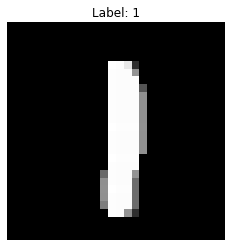

In [45]:
rand_idx = np.random.randint(len(train_x))

plt.imshow(train_x[rand_idx], 'gray')
plt.title("Label: {}".format(train_y[rand_idx]))
plt.axis('off')

plt.show()

(3) Define LSTM Structure

<img src='./lstm_2.png' width="800" height="200">

In [47]:
n_step = 14
n_input = 28

# LSTM shape
n_lstm1 = 10
n_lstm2 = 10

# fully connected
n_hidden = 100
n_output = 28

In [48]:
lstm_network = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_step, n_input)),
    tf.keras.layers.LSTM(n_lstm1, return_sequences=True),
    tf.keras.layers.LSTM(n_lstm2),
    tf.keras.layers.Dense(n_hidden),
    tf.keras.layers.Dense(n_output)])

In [49]:
lstm_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 10)            1560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 100)               1100      
_________________________________________________________________
dense_1 (Dense)              (None, 28)                2828      
Total params: 6,328
Trainable params: 6,328
Non-trainable params: 0
_________________________________________________________________


(4) Define Cost, Initializer and Optimizer Loss

- Regression: Squared loss

<img src='./lstm_3.png' width="200" height="100">

Initializer
- Initialize all the empty variables

Optimizer
- AdamOptimizer: the most popular optimizer

In [50]:
lstm_network.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.MeanSquaredError())

(5) Define optimization configuration and then optimize

Highly recommand to use GPU or Colab.

In [51]:
def make_batch(data, size=50, seed=1207):
    np.random.seed(seed)
    random_indices = np.random.choice(len(data), size, replace=False)
    random_train = data[random_indices,]
    
    return random_train

In [53]:
n_iter = 150
n_prt = 5
batch_size = 50

for i in range(n_iter):
    batch_imgs = make_batch(train_x, size=batch_size)
    for j in range(batch_size):
        for n in range(n_step):
            loss = lstm_network.train_on_batch(
                batch_imgs[j, n:n+n_step].reshape(-1, 14, 28),
                batch_imgs[j, n+n_step].reshape(-1, 1, 28))

    if i % n_prt == 0:
        print('Iteration:', i, end='\t')
        print('MSE_Loss:', loss)

Iteration: 0	MSE_Loss: 0.0028738968539983034
Iteration: 5	MSE_Loss: 0.0010584882693365216
Iteration: 10	MSE_Loss: 0.0007151655736379325
Iteration: 15	MSE_Loss: 0.0007429532706737518
Iteration: 20	MSE_Loss: 0.0007776379934512079
Iteration: 25	MSE_Loss: 0.0007343785837292671
Iteration: 30	MSE_Loss: 0.0006292552570812404
Iteration: 35	MSE_Loss: 0.0005137105472385883
Iteration: 40	MSE_Loss: 0.00039782203384675086
Iteration: 45	MSE_Loss: 0.0003238289791624993
Iteration: 50	MSE_Loss: 0.00028380710864439607
Iteration: 55	MSE_Loss: 0.00024279743956867605
Iteration: 60	MSE_Loss: 0.00025910866679623723
Iteration: 65	MSE_Loss: 0.00022751910728402436
Iteration: 70	MSE_Loss: 0.0002465243451297283
Iteration: 75	MSE_Loss: 0.00023259904992301017
Iteration: 80	MSE_Loss: 0.00026687479112297297
Iteration: 85	MSE_Loss: 0.0003110299294348806
Iteration: 90	MSE_Loss: 0.0003306402068119496
Iteration: 95	MSE_Loss: 0.0003674388863146305
Iteration: 100	MSE_Loss: 0.00034632833558134735
Iteration: 105	MSE_Loss: 0.

KeyboardInterrupt: 

(6) Test or Evaluate

- Predict the MNIST image
- MNIST is 28 x 28 image. The model predicts a piece of 1 x 28 image.
- First, 14 x 28 image will be feeded into a model, then the model predict the last 14 x 28 image, recursively.

In [54]:
def generate(data):
    test_data = data.copy()
    gen_signal = []
    for i in range(n_step):
        test_pred = lstm_network.predict(test_data)
        gen_signal.append(test_pred.ravel())

        test_data = np.concatenate([test_data[:, 1:, :], 
                                    test_pred[:, np.newaxis, :]], axis=1)

    gen_signal = np.concatenate(gen_signal)
    generated_image = np.vstack([data.reshape(-1, 28), gen_signal.reshape(-1, 28)])
    
    return generated_image

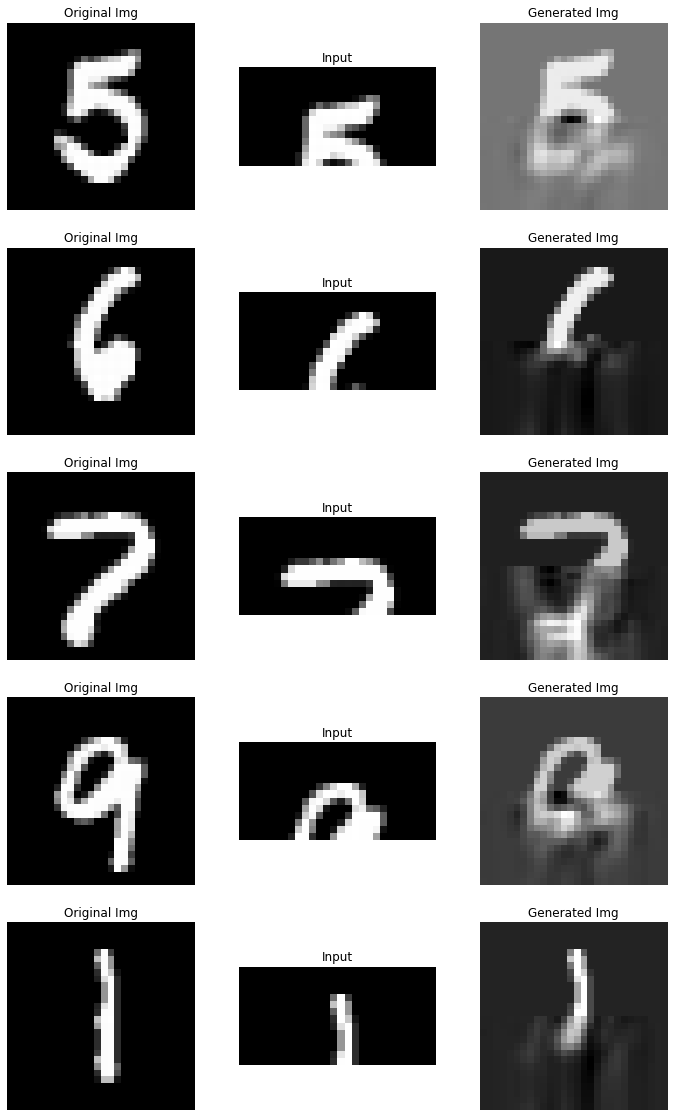

In [58]:
N_rows = 5
test_indexes = np.random.randint(0, test_x.shape[0], N_rows)

original_imgs = test_x
input_imgs = test_x[:, :14, :]
generated_imgs = [generate(test_x[index, :14, :].reshape(-1, n_step, 28)) 
                  for index in test_indexes]

fig, axes = plt.subplots(N_rows, 3, figsize=(12, 20))
for i, j in enumerate(test_indexes):
    axes[i, 0].imshow(original_imgs[j].reshape(-1, 28), 'gray', interpolation='nearest')
    axes[i, 0].set_title('Original Img')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(input_imgs[j].reshape(-1, 28), 'gray', interpolation='nearest')
    axes[i, 1].set_title('Input')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(generated_imgs[i].reshape(-1, 28), 'gray', interpolation='nearest')
    axes[i, 2].set_title('Generated Img')
    axes[i, 2].axis('off')

plt.show()